<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/poisson_model_2.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(poisson_model_2_notebook)=
# Modello di Poisson: derivazione analitica e MCMC

In questo capitolo, spiegheremo la derivazione analitica della distribuzione a posteriori utilizzando una funzione di verosimiglianza di Poisson e una distribuzione a priori gamma. Inoltre, dimostreremo l'equivalenza tra la soluzione ottenuta analiticamente e quella ricavata attraverso l'utilizzo di PyMC.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.special as sp
from math import factorial
import pymc as pm
import pymc.sampling_jax
from scipy.integrate import quad
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

Ricordiamo che la [distribuzione di Poisson](https://it.wikipedia.org/wiki/Distribuzione_di_Poisson) è data da:

$$
f(y_i|\lambda)=\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
$$

dove $\lambda>0$. Risulta inoltre che $E(Y)=\lambda$ e $Var(Y)=\lambda$.

Simuliamo 100 osservazioni dalla distribuzione di Poisson con un parametro $\lambda$ pari a 2.

In [3]:
n = 100
lam_true = 2
y = rng.poisson(lam=lam_true, size=n)
print(y)

[4 3 3 2 1 5 2 0 1 3 1 0 1 4 3 1 1 4 1 0 4 2 0 1 2 0 1 4 2 0 2 1 2 2 0 0 5
 2 0 2 2 4 2 1 2 0 1 3 0 3 3 1 2 0 2 1 2 2 2 4 3 2 6 3 0 3 0 1 1 2 3 0 1 1
 3 3 0 2 3 1 2 1 6 0 3 3 2 2 3 0 1 2 2 1 0 0 1 3 3 1]


Esaminiamo la distribuzione dei 100 valori così ottenuti.

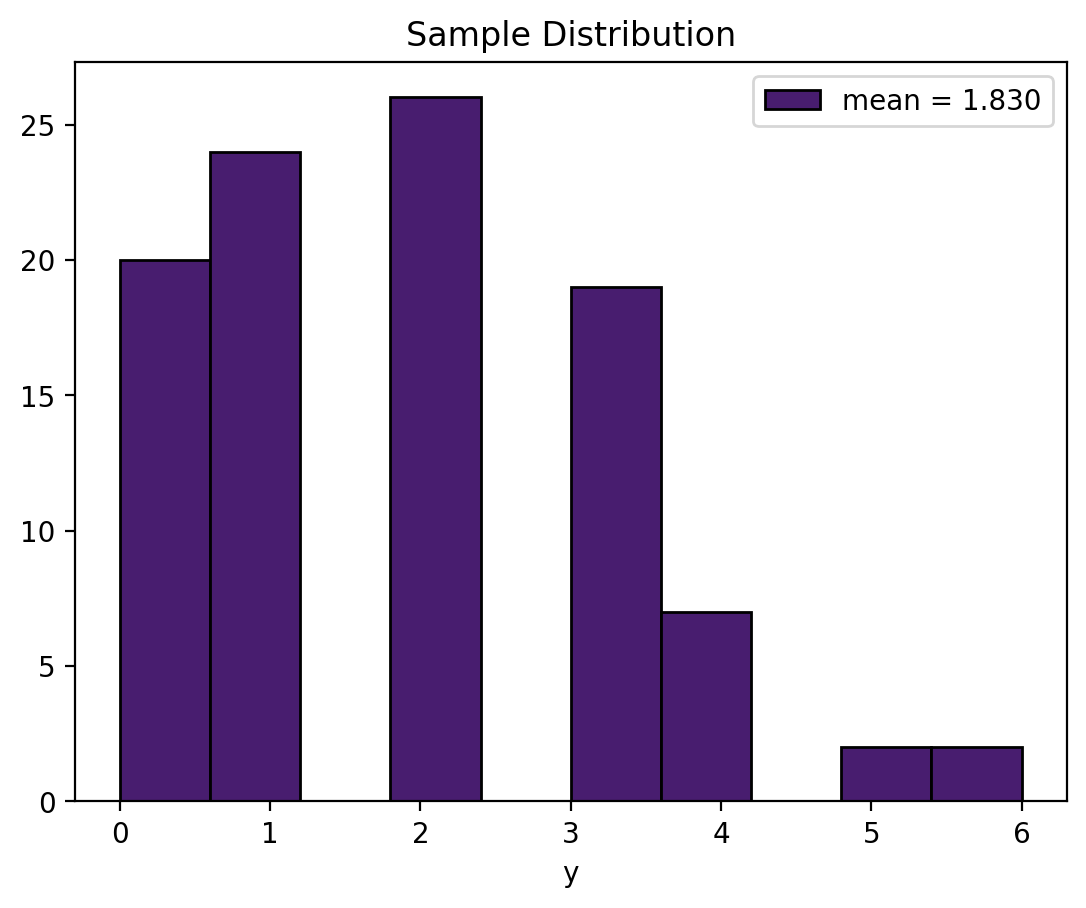

In [4]:
plt.hist(y, edgecolor="black", bins=10)  # You can change the number of bins if desired
mean_y = y.mean()
plt.legend([f"mean = {mean_y:0.3f}"], loc="upper right")
plt.title("Sample Distribution")
plt.xlabel("y")
plt.show()

### Distribuzione a priori Gamma

Consideriamo una distribuzione a priori [gamma](https://en.wikipedia.org/wiki/Gamma_distribution) per il parametro $\lambda \sim \Gamma(a,b)$. Ricordiamo che la funzione di densità della distribuzione gamma è data da

$$
f(\lambda)=\frac{b^a}{\Gamma(a)}\lambda^{a-1} e^{-b\lambda},
$$

dove $a > 0$ rappresenta il parametro di forma e $b > 0$ è il parametro di scala, spesso chiamato anche parametro di tasso.

Il *valore atteso* e la *varianza* della distribuzione gamma sono 

$$
E(\lambda)=\frac{a}{b}
\quad
\text{e}
\quad
Var(\lambda)=\frac{a}{b^2}.
$$

Nella presente simulazione useremo una distribuzione a priori Gamma con i seguenti parametri.

In [5]:
a = 3  # shape
b = 1  # rate = 1/scale

Visualizziamo la distribuzione Gamma prescelta.

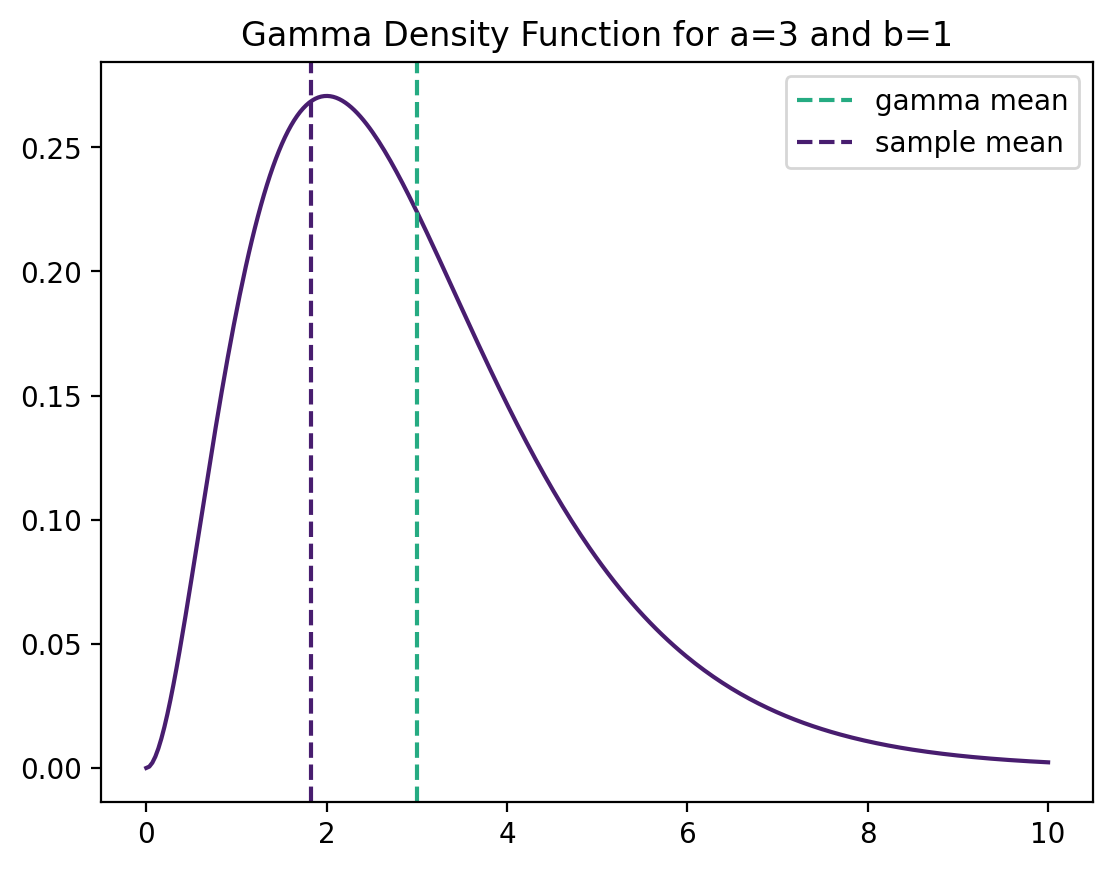

In [9]:
x = np.linspace(start=0, stop=10, num=300)

plt.plot(x, stats.gamma.pdf(x, a=a, scale=1 / b))
plt.axvline(x=a / b, linestyle="--", color="C2", label="gamma mean")
plt.axvline(x=y.mean(), linestyle="--", label="sample mean")
plt.legend()
plt.title(f"Gamma Density Function for a={a} and b={b}")
plt.show()

Creiamo una funzione che calcola e ritorna il valore della funzione di densità della distribuzione gamma per un dato valore di ascissa.

In [10]:
def prior(lam):
    return stats.gamma.pdf(lam, a=a, scale=1/b)

### Verosimiglianza

Poiché le osservazioni sono indipendenti, la funzione di verosimiglianza è

$$
f(y|\lambda)=\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
=\frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^{n}y_i!}.
$$

Nella parte sinistra dell'equazione, viene moltiplicata la probabilità della distribuzione di Poisson per ogni singola osservazione $y_i$:

$$
\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}.
$$

Nella parte destra dell'equazione, viene semplificata l'espressione:

- $ e^{-\lambda} $ viene moltiplicato $ n $ volte, il che diventa $ e^{-n\lambda} $
- $ \lambda $ viene elevato alla potenza di ogni $ y_i $, il che diventa $ \lambda^{\sum_{i=1}^n y_i} $
- Il denominatore rimane come prodotto dei fattoriali delle osservazioni $ y_i $, cioè $ \prod_{i=1}^{n}y_i! $

In [11]:
def log_likelihood(lam, y):
    log_factorials = [np.log(factorial(i)) for i in y]
    log_numerator = (-lam * y.size) + (y.sum() * np.log(lam))
    log_denominator = np.sum(log_factorials)
    return np.exp(log_numerator - log_denominator)

### Distribuzione a posteriori per $\lambda$ (a meno di una costante di proporzionalità)

Poiché ci interessa solamente la struttura della distribuzione a posteriori, senza tener conto della  costante di normalizzazione), abbiamo:

$$
\begin{align}
f(\lambda|y)\propto & \: \text{likelihood} \times \text{prior}\\
\propto & \quad f(y \mid \lambda)f(\lambda)\\
\propto & \quad e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i} \lambda^{a-1} e^{-b\lambda}\\
\propto & \quad \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}.\\
\end{align}
$$

Scriviamo una funzione Python che ritorna la funzione a posteriori per $\lambda$ a meno di una costante di proporzionalità -- ovvero la funzione a posteriori non normalizzata.

In [12]:
# Define the posterior distribution (up to a constant)
def posterior_up_to_constant(lam, y):
    return log_likelihood(lam=lam, y=y) * prior(lam)

### Distribuzione a posteriori per $\lambda$ 

Per trovare la distribuzione a posteriori, è necessario normalizzare la funzione non normalizzata che abbiamo definito precedentemente, in modo che l'area totale sotto la curva sia unitaria. Questo significa che dobbiamo trovare una costante di normalizzazione, che è ottenuta calcolando l'integrale della funzione non normalizzata su tutto il dominio di λ.

In [13]:
lower_bound = 0
upper_bound = 10

def integrand(lam, y):
    return posterior_up_to_constant(lam, y)

normalizing_constant, _ = quad(integrand, lower_bound, upper_bound, args=(y,))

Ora possiamo definire la funzione normalizzata a posteriori.

In [14]:
def posterior(lam, y):
    return posterior_up_to_constant(lam, y) / normalizing_constant

Esaminiamo graficamente la soluzione ottenuta.

In [12]:
x = np.linspace(start=0, stop=10, num=300)

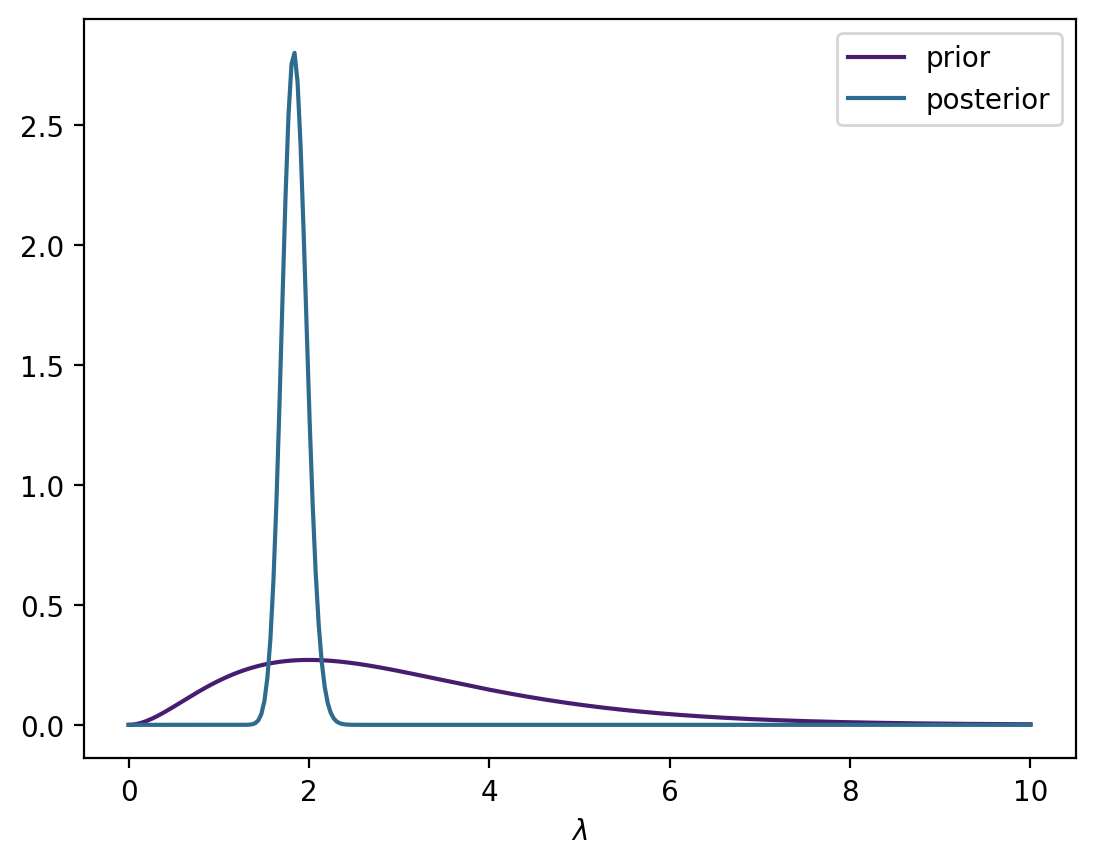

In [16]:
plt.plot(x, prior(x), label="prior")
plt.plot(x, posterior(x, y), label="posterior")
plt.legend()
plt.xlabel("$\lambda$")
plt.show()

### Soluzione analitica

La distribuzione a priori per $ \lambda $ è una gamma con parametri $ a $ e $ b $, e la verosimiglianza è proporzionale a $ \lambda^{\left(\sum_{i=1}^n y_i\right)-1} e^{-(n\lambda)} $. I dati $ y $ seguono una distribuzione di Poisson.

Quando moltiplichiamo la distribuzione a priori gamma per questa verosimiglianza, otteniamo la distribuzione a posteriori non normalizzata:

$$
f(\lambda|y) \propto \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}.
$$

Questa espressione ha esattamente la forma della funzione di densità di probabilità di una distribuzione gamma, ma con parametri aggiornati: 

- il parametro di forma è $ \sum_{i=1}^n y_i + a $,
- il parametro di scala è $ n + b $. 

Quindi, possiamo scrivere la distribuzione a posteriori normalizzata come:

$$
f(\lambda|y) = \Gamma\left(\sum_{i=1}^n y_i+a, n+b\right).
$$

Questo è un esempio di [coppia coniugata](https://en.wikipedia.org/wiki/Conjugate_prior), dove la scelta della distribuzione a priori consente di ottenere una distribuzione a posteriori dello stesso tipo della distribuzione a priori. In questo caso, una distribuzione gamma a priori con una verosimiglianza di Poisson porta a una distribuzione gamma a posteriori. 

Riscriviamo dunque in Python la funzione per la distribuzione a posteriori.

In [17]:
def posterior_an(lam, y):
    shape = a + y.sum()
    rate = b + y.size
    return stats.gamma.pdf(lam, shape, scale=1 / rate)

Con la funzione `posterior_an` possiamo ottenere lo stesso grafico creato in precedenza.

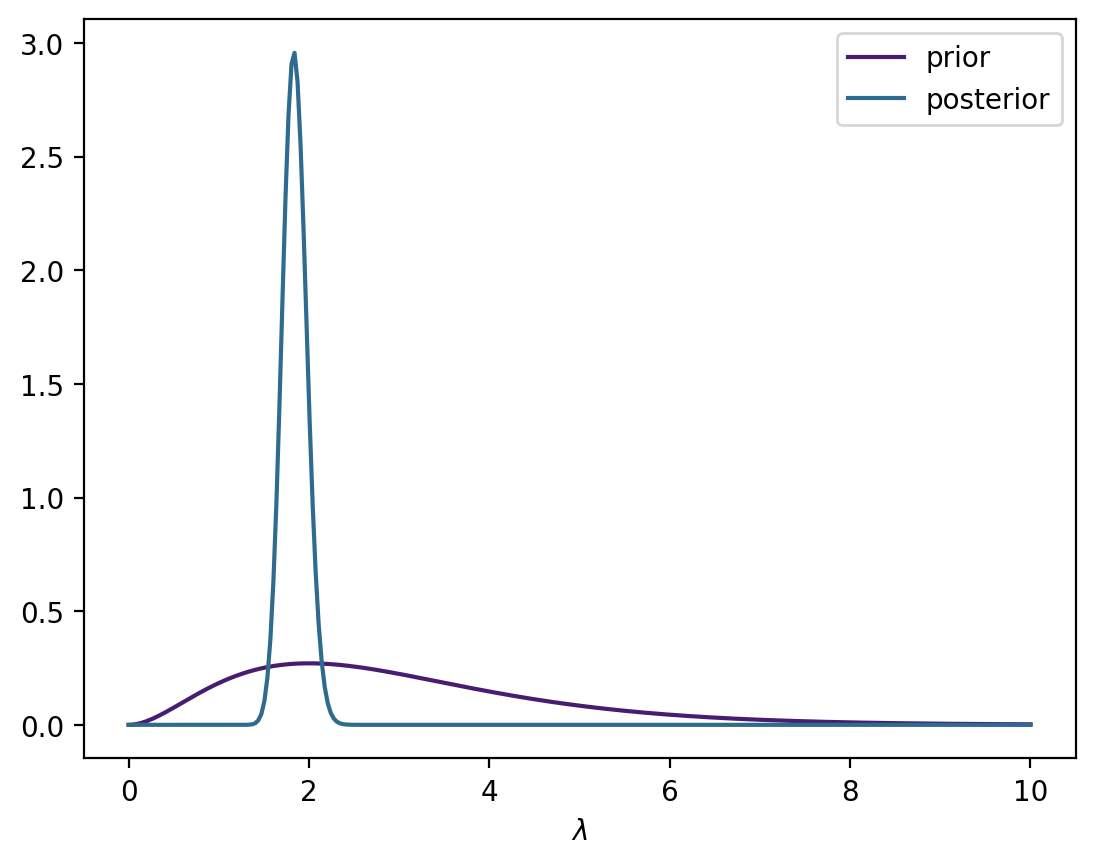

In [18]:
plt.plot(x, prior(x), label="prior")
plt.plot(x, posterior_an(x, y), label="posterior")
plt.legend()
plt.xlabel("$\lambda$")
plt.show()

Procediamo ora con il calcolo della soluzione analitica per la media della distribuzione a posteriori del parametro $\lambda$.

In [19]:
# Posterior gamma parameters.
shape = a + y.sum()
rate = b + y.size

# Posterior mean.
print(f"Posterior Mean = {shape / rate: 0.3f}")

Posterior Mean =  1.842


## Soluzione con PyMC

Poniamoci il problema di replicare i risulati precedenti usando PyMC.  Specifichiamo il modello.

In [20]:
df = pd.DataFrame()
df["y"] = y

In [21]:
with pm.Model() as model:
    data = pm.ConstantData("data", df["y"])
    # Define the prior of the parameter lambda.
    lam = pm.Gamma("lambda", alpha=a, beta=b)
    # Define the likelihood function.
    pm.Poisson("y", mu=lam, observed=data)

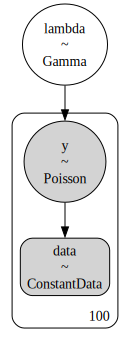

In [22]:
pm.model_to_graphviz(model)

Eseguiamo il campionamento.

In [23]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:08.893081
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 684.00it/s]

Sampling time =  0:00:03.291175
Transforming variables...
Transformation time =  0:00:00.025815


Utilizziamo la libreria ArviZ per creare un grafico che rappresenti la distribuzione a posteriori e per mostrare la traccia corrispondente.

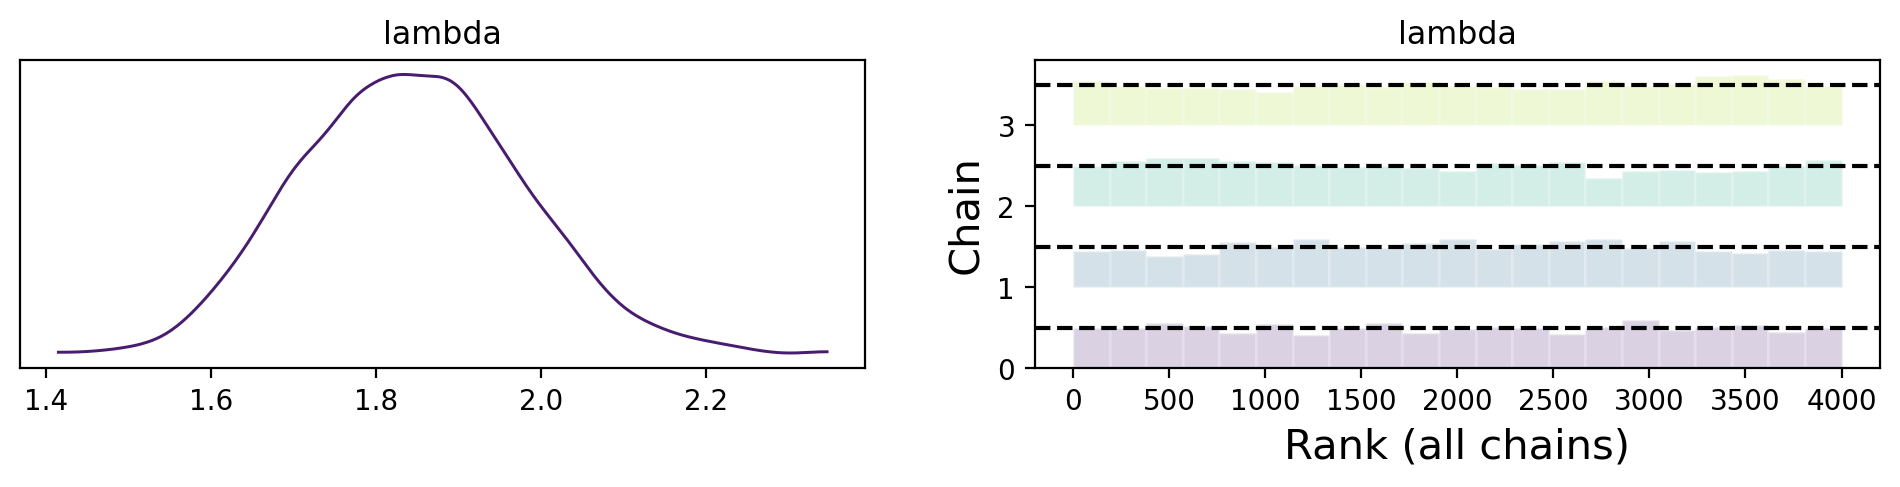

In [25]:
az.plot_trace(data=idata, combined=True, kind="rank_bars")
plt.show()

Troviamo la media della distribuzione a posteriori di $\lambda$.

In [26]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,1.844,0.135,1.592,2.087,0.003,0.002,1587.0,1675.0,1.0


Si noti che, mediante l'impiego del campionamento MCMC, abbiamo ottenuto una stima precisa del parametro $\lambda$, facendo ricorso a un campione contenente soltanto 100 osservazioni.

## Watermark

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 08 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

scipy     : 1.11.2
seaborn   : 0.12.2
pandas    : 2.1.0
pymc      : 5.8.0
numpy     : 1.25.2
matplotlib: 3.7.2
arviz     : 0.16.1

Watermark: 2.4.3

